In [1]:
from trackers.ocsort_tracker.association import *
import numpy as np
from __future__ import print_function
import torch
import cv2

/home/leejaehyeok/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_file = '/home/leejaehyeok/trackingProject/ocsort/OC_SORT/samplepeople.jpg'
x = cv2.imread(img_file)
#사진의 최종 tensor (postprocess 이후 값, shape=(N, 7))
output = [[192.0702,  31.2105, 328.1173, 393.1645,   0.9985,   0.9805,   0.0000],
        [ 26.8002,  26.0286, 146.0435, 388.6902,   0.9966,   0.9814,   0.0000],
        [ 16.3157, 409.7150, 127.1375, 798.0350,   0.9990,   0.9790,   0.0000],
        [196.9685, 414.3482, 330.9065, 795.9019,   0.9980,   0.9795,   0.0000],
        [391.8076,  14.7951, 505.0361, 394.8612,   0.9990,   0.9785,   0.0000],
        [386.4258, 419.2980, 487.8242, 795.6707,   0.9995,   0.9766,   0.0000],
        [577.7744,  21.5551, 681.8818, 388.4917,   0.9985,   0.9766,   0.0000],
        [554.2709, 404.1043, 687.1666, 800.0832,   0.9990,   0.9707,   0.0000]]
output = torch.Tensor(output).to(torch.device('cuda:0'))

In [3]:
def k_previous_obs(observations, cur_age, k):
    if len(observations) == 0:
        return [-1, -1, -1, -1, -1]
    for i in range(k):
        dt = k - i
        if cur_age - dt in observations:
            return observations[cur_age-dt]
    max_age = max(observations.keys())
    return observations[max_age]

def convert_bbox_to_z(bbox):
    """
    Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
      [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
      the aspect ratio
    """
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = bbox[0] + w/2.
    y = bbox[1] + h/2.
    s = w * h  # scale is just area
    r = w / float(h+1e-6)
    return np.array([x, y, s, r]).reshape((4, 1))


def convert_x_to_bbox(x, score=None):
    """
    Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
      [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right
    """
    w = np.sqrt(x[2] * x[3])
    h = x[2] / w
    if(score == None):
      return np.array([x[0]-w/2., x[1]-h/2., x[0]+w/2., x[1]+h/2.]).reshape((1, 4))
    else:
      return np.array([x[0]-w/2., x[1]-h/2., x[0]+w/2., x[1]+h/2., score]).reshape((1, 5))


def speed_direction(bbox1, bbox2):
    cx1, cy1 = (bbox1[0]+bbox1[2]) / 2.0, (bbox1[1]+bbox1[3])/2.0
    cx2, cy2 = (bbox2[0]+bbox2[2]) / 2.0, (bbox2[1]+bbox2[3])/2.0
    speed = np.array([cy2-cy1, cx2-cx1])
    norm = np.sqrt((cy2-cy1)**2 + (cx2-cx1)**2) + 1e-6
    return speed / norm

In [4]:
class KalmanBoxTracker(object):
    """
    This class represents the internal state of individual tracked objects observed as bbox.
    """
    count = 0

    def __init__(self, bbox, delta_t=3, orig=False):
        """
        Initialises a tracker using initial bounding box.

        """
        # define constant velocity model
        if not orig:
          from trackers.ocsort_tracker.kalmanfilter import KalmanFilterNew as KalmanFilter
          self.kf = KalmanFilter(dim_x=7, dim_z=4)
        else:
          from filterpy.kalman import KalmanFilter
          self.kf = KalmanFilter(dim_x=7, dim_z=4)
        # states : [u, v, s, r, dot_u, dot_v, dot_s]
        self.kf.F = np.array([[1, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 1], [
                            0, 0, 0, 1, 0, 0, 0],  [0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1]])
        self.kf.H = np.array([[1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0]])

        self.kf.R[2:, 2:] *= 10. # Q (uncertainty/noise of measurement) diag[1, 1, 10, 10]
        self.kf.P[4:, 4:] *= 1000.  # sigma (covariance matrix) give high uncertainty to the unobservable initial velocities diag[1,1,1,1,1000,1000,1000]
        self.kf.P *= 10. # diag[10,10,10,10,10^4,10^4,10^4]
        self.kf.Q[-1, -1] *= 0.01 # R (uncertainty/noise of propagation) diag[1,1,1,1,1,1, 0.01] area variation is not big
        self.kf.Q[4:, 4:] *= 0.01 # diagdiag[1,1,1,1, 0.01, 0.01, 10^(-4)] # he or she wanted velocity doesn't have big noise

        self.kf.x[:4] = convert_bbox_to_z(bbox)
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count
        KalmanBoxTracker.count += 1 # Every assignment, count variable gets one
        self.history = []
        self.hits = 0
        self.hit_streak = 0
        self.age = 0
        """
        NOTE: [-1,-1,-1,-1,-1] is a compromising placeholder for non-observation status, the same for the return of 
        function k_previous_obs. It is ugly and I do not like it. But to support generate observation array in a 
        fast and unified way, which you would see below k_observations = np.array([k_previous_obs(...]]), let's bear it for now.
        """
        # OCSORT를 위한 새로운 변수
        self.last_observation = np.array([-1, -1, -1, -1, -1])  # placeholder
        self.observations = dict()
        self.history_observations = []
        self.velocity = None
        self.delta_t = delta_t

    def update(self, bbox):
        """
        Updates the state vector with observed bbox.
        """
        if bbox is not None:
            if self.last_observation.sum() >= 0:  # no previous observation
                previous_box = None
                for i in range(self.delta_t):
                    dt = self.delta_t - i
                    if self.age - dt in self.observations:
                        previous_box = self.observations[self.age-dt]
                        break
                if previous_box is None:
                    previous_box = self.last_observation
                """
                  Estimate the track speed direction with observations \Delta t steps away
                """
                self.velocity = speed_direction(previous_box, bbox)
            
            """
              Insert new observations. This is a ugly way to maintain both self.observations
              and self.history_observations. Bear it for the moment.
            """
            self.last_observation = bbox
            self.observations[self.age] = bbox
            self.history_observations.append(bbox)

            self.time_since_update = 0
            self.history = []
            self.hits += 1
            self.hit_streak += 1
            self.kf.update(convert_bbox_to_z(bbox))
        else:
            self.kf.update(bbox)

    def predict(self):
        """
        Advances the state vector and returns the predicted bounding box estimate.
        return latest bbox estimation with kalman filter
        """
        if((self.kf.x[6]+self.kf.x[2]) <= 0): # area + dot(area) <=0
            self.kf.x[6] *= 0.0 # make dot(area) 0.0

        self.kf.predict() # predict next state (prior)
        self.age += 1
        if(self.time_since_update > 0):
            self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return convert_x_to_bbox(self.kf.x)


"""
    We support multiple ways for association cost calculation, by default
    we use IoU. GIoU may have better performance in some situations. We note 
    that we hardly normalize the cost by all methods to (0,1) which may not be 
    the best practice.
"""
ASSO_FUNCS = {  "iou": iou_batch,
                "giou": giou_batch,
                "ciou": ciou_batch,
                "diou": diou_batch,
                "ct_dist": ct_dist}

In [5]:
# OCSORT 클래스 구현
max_age = 30
min_hits = 3
iou_threshold = 0.3
trackers = []
frame_count = 0
det_thresh = 0.97
delta_t = 3
asso_func = ASSO_FUNCS['iou']
inertia = 0.2
use_byte = False

# update 함수 구현
if output is None:
    result = np.empty((0, 5))

frame_count += 1
 # post_process detections
if output.shape[1] == 5:
    scores = output[:, 4]
    bboxes = output[:, :4]
else:
    output = output.cpu().numpy()
    scores = output[:, 4] * output[:, 5]
    bboxes = output[:, :4]  # x1y1x2y2
img_h, img_w = 521, 464
scale = min(800/float(img_h), 1440/float(img_w))
print(scale)
# scale bbox to fit bbox to original image
bboxes /= scale

1.5355086372360844


In [6]:
# bbox에 score 추가
dets = np.concatenate((bboxes, np.expand_dims(scores, axis=-1)), axis=1)
print(dets.shape)

(8, 5)


In [7]:
inds_low = scores > 0.1
inds_high = scores < 0.97 # 원래 0.97에 det_thresh가 들어가야함. 실험을 위한 값을 넣음

# det_thresh > score > 0.1 for second matching
inds_second = np.logical_and(inds_low, inds_high)
# detections for second matching
print(inds_second)
dets_second = dets[inds_second]
print(dets_second)

[False False False False False False False  True]
[[360.9689     263.17294    447.51727    521.0542       0.96972936]]


In [9]:
# remain indices scores > det_threshold
remain_inds = scores > 0.97
dets = dets[remain_inds]
print(dets)

[[125.085724    20.325838   213.6864     256.04837      0.97902924]
 [ 17.45363     16.951126    95.11083    253.13449      0.9780632 ]
 [ 10.6256     266.8269      82.798294   519.7203       0.97802097]
 [128.27574    269.84427    215.50285    518.3311       0.977541  ]
 [255.16469      9.635309   328.90475    257.15335      0.97752154]
 [251.6598     273.06784    317.6955     518.18054      0.97611165]
 [376.27557     14.037759   444.0755     253.00522      0.9751351 ]]


In [10]:
trackers = []
for i in range(len(dets)):
    trk = KalmanBoxTracker(dets[i, :], delta_t=delta_t)
    trackers.append(trk)
print(trackers)

[<__main__.KalmanBoxTracker object at 0x7fd403ba7580>, <__main__.KalmanBoxTracker object at 0x7fd3fc1267c0>, <__main__.KalmanBoxTracker object at 0x7fd403ba72e0>, <__main__.KalmanBoxTracker object at 0x7fd403ba7d00>, <__main__.KalmanBoxTracker object at 0x7fd5143d9130>, <__main__.KalmanBoxTracker object at 0x7fd3b4132d00>, <__main__.KalmanBoxTracker object at 0x7fd3c77cb430>]


In [11]:
# tracker(type: kalmanboxtracker) 추가 후 실행
# get predicted locations from existing trackers
trks = np.zeros((len(trackers), 5))
to_del = []
ret = []
for t, trk in enumerate(trks):
    # predict함수는 bbox만 반환
    pos = trackers[t].predict()[0]
    print(type(pos),"prediced shape", pos.shape)
    trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
    if np.any(np.isnan(pos)):
        to_del.append(t)

<class 'numpy.ndarray'> prediced shape (4,)
<class 'numpy.ndarray'> prediced shape (4,)
<class 'numpy.ndarray'> prediced shape (4,)
<class 'numpy.ndarray'> prediced shape (4,)
<class 'numpy.ndarray'> prediced shape (4,)
<class 'numpy.ndarray'> prediced shape (4,)
<class 'numpy.ndarray'> prediced shape (4,)


In [13]:
# predict에서 None뜬 (predict가 안된) 박스 제거
trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
print(trks)
for t in reversed(to_del):
    trackers.pop(t)

# velcity는 당연하게도 update를 한 후 생긴다. 초기화 안되면 None
velocities = np.array(
    [trk.velocity if trk.velocity is not None else np.array((0,0)) for trk in trackers])
# 최근 det bbox + score (shape(5))
last_boxes = np.array([trk.last_observation for trk in trackers])
# k 시간 전 det bbox + socre (shape(5))
k_observations = np.array(
    [k_previous_obs(trk.observations, trk.age, delta_t) for trk in trackers])

[[125.08572444  20.3258391  213.6864008  256.04837126   0.        ]
 [ 17.45363035  16.95112529  95.11083422 253.13449178   0.        ]
 [ 10.6255991  266.82690113  82.79829197 519.72027905   0.        ]
 [128.27574259 269.84427118 215.50285238 518.33111334   0.        ]
 [255.16468853   9.63531012 328.90475422 257.15334421   0.        ]
 [251.65980528 273.06784001 317.69549562 518.18054255   0.        ]
 [376.27557404  14.03775941 444.07550018 253.00521125   0.        ]]


In [14]:
print(velocities)
print(last_boxes)
print(k_observations)

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
[[-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]
[[-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]]


In [15]:
# First round of associations, returns are indices of matched dets and trks np.concat((det index, trk index)), unmatched : np.array(unmatched indices)
matched, unmatched_dets, unmatched_trks = associate(
    dets, trks, iou_threshold, velocities, k_observations, inertia
)

In [16]:
print("matched", matched)
print("unmatched_dets", unmatched_dets)
print("unmatched_trks", unmatched_trks)

matched [[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]
 [5 5]
 [6 6]]
unmatched_dets []
unmatched_trks []


In [17]:
for m in matched:
    # k time 전의 det와 현재 det의 velocity direction도 여기서 초기화됨 (last_observation이 없어 계속 None)
    trackers[m[1]].update(dets[m[0], :])
    

In [19]:
for i, trk in enumerate(trackers):
    print(trk.get_state())

[[125.08572444  20.3258391  213.6864008  256.04837126]]
[[ 17.45363035  16.95112529  95.11083422 253.13449178]]
[[ 10.6255991  266.82690113  82.79829197 519.72027905]]
[[128.27574259 269.84427118 215.50285238 518.33111334]]
[[255.16468853   9.63531012 328.90475422 257.15334421]]
[[251.65980528 273.06784001 317.69549562 518.18054255]]
[[376.27557404  14.03775941 444.07550018 253.00521125]]


In [20]:
for m in matched:
    print(trackers[m[1]].velocity)

None
None
None
None
None
None
None


In [ ]:
# BYTE association (이건 아직 안쓰므로 나중에 이해하기)

# if self.use_byte and len(dets_second) > 0 and unmatched_trks.shape[0] > 0:
#     u_trks = trks[unmatched_trks]
#     iou_left = self.asso_func(dets_second, u_trks)          # iou between low score detections and unmatched tracks
#     iou_left = np.array(iou_left)
#     if iou_left.max() > self.iou_threshold:
#         """
#             NOTE: by using a lower threshold, e.g., self.iou_threshold - 0.1, you may
#             get a higher performance especially on MOT17/MOT20 datasets. But we keep it
#             uniform here for simplicity
#         """
#         matched_indices = linear_assignment(-iou_left)
#         to_remove_trk_indices = []
#         for m in matched_indices:
#             det_ind, trk_ind = m[0], unmatched_trks[m[1]]
#             if iou_left[m[0], m[1]] < self.iou_threshold:
#                 continue
#             self.trackers[trk_ind].update(dets_second[det_ind, :])
#             to_remove_trk_indices.append(trk_ind)
#         unmatched_trks = np.setdiff1d(unmatched_trks, np.array(to_remove_trk_indices))


In [21]:
# Second round of association by OCR (pseudo code setp 2)
if unmatched_dets.shape[0] > 0 and unmatched_trks.shape[0] > 0:
    left_dets = dets[unmatched_dets]
    left_trks = last_boxes[unmatched_trks]
    iou_left = asso_func(left_dets, left_trks)
    iou_left = np.array(iou_left)
    if iou_left.max() > iou_threshold:
        """
            NOTE: by using a lower threshold, e.g., self.iou_threshold - 0.1, you may
            get a higher performance especially on MOT17/MOT20 datasets. But we keep it
            uniform here for simplicity
        """
        rematched_indices = linear_assignment(-iou_left)
        to_remove_det_indices = []
        to_remove_trk_indices = []
        for m in rematched_indices:
            det_ind, trk_ind = unmatched_dets[m[0]], unmatched_trks[m[1]]
            # rematch 된것 중에서도 iou threshold를 못넘기면 버림
            if iou_left[m[0], m[1]] < iou_threshold:
                continue
            trackers[trk_ind].update(dets[det_ind, :])
            to_remove_det_indices.append(det_ind)
            to_remove_trk_indices.append(trk_ind)
        # rematched 된 indices 제외
        unmatched_dets = np.setdiff1d(unmatched_dets, np.array(to_remove_det_indices))
        unmatched_trks = np.setdiff1d(unmatched_trks, np.array(to_remove_trk_indices))

In [22]:
# unmatched 된 tracker도 update 해줌(x_,sigma_가 그대로 x, sigma posterior로 저장됨 + z는 np.array([None]*dim_z)).
"""
        Add a new measurement (z) to the Kalman filter.
        If z is None, nothing is computed. However, x_post and P_post are
        updated with the prior (x_prior, P_prior), and self.z is set to None.
        Parameters
"""
if m in unmatched_trks:
    trackers[m].update(None)

/tmp/ipykernel_21330/4007948956.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if m in unmatched_trks:


In [23]:
# create and initialise new trackers for unmatched detections
for i in unmatched_dets:
    trk = KalmanBoxTracker(dets[i, :], delta_t=delta_t)
    trackers.append(trk)
i = len(trackers)
for trk in reversed(trackers):
    if trk.last_observation.sum() < 0:
        # kf.x's bbox state
        d = trk.get_state()[0]
    else:
        """
            this is optional to use the recent observation or the kalman filter prediction,
            we didn't notice significant difference here
        """
        d = trk.last_observation[:4]
    if (trk.time_since_update < 1) and (trk.hit_streak >= min_hits or frame_count <= min_hits):
        # +1 as MOT benchmark requires positive
        ret.append(np.concatenate((d, [trk.id+1])).reshape(1, -1))
    i -= 1
    # remove dead tracklet
    if(trk.time_since_update > max_age):
        trackers.pop(i)
if(len(ret)>0):
    result = np.concatenate(ret)

In [24]:
print(result)

[[376.27557373  14.03775883 444.07550049 253.00521851  15.        ]
 [251.6598053  273.06784058 317.69549561 518.18054199  14.        ]
 [255.16468811   9.63530922 328.90475464 257.15335083  13.        ]
 [128.27574158 269.8442688  215.50285339 518.33111572  12.        ]
 [ 10.62559986 266.8269043   82.79829407 519.72027588  11.        ]
 [ 17.45363045  16.9511261   95.11083221 253.13449097  10.        ]
 [125.08572388  20.32583809 213.68640137 256.04837036   9.        ]]


In [25]:
def get_color(idx):
    idx = idx * 3
    color = ((37 * idx) % 255, (17 * idx) % 255, (29 * idx) % 255)

    return color

def plot_tracking(image, tlwhs, obj_ids, scores=None, frame_id=0, fps=0., ids2=None):
    # 이미 preproc에서 하므로 필요 없음
    #im = np.ascontiguousarray(np.copy(image))
    im = image
    im_h, im_w = im.shape[:2]

    top_view = np.zeros([im_w, im_w, 3], dtype=np.uint8) + 255

    #text_scale = max(1, image.shape[1] / 1600.)
    #text_thickness = 2
    #line_thickness = max(1, int(image.shape[1] / 500.))
    text_scale = 2
    text_thickness = 2
    line_thickness = 3

    radius = max(5, int(im_w/140.))
    cv2.putText(im, 'frame: %d fps: %.2f num: %d' % (frame_id, fps, len(tlwhs)),
                (0, int(15 * text_scale)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), thickness=2)

    for i, tlwh in enumerate(tlwhs):
        x1, y1, w, h = tlwh
        intbox = tuple(map(int, (x1, y1, x1 + w, y1 + h)))
        
        # median filter
        """
        distance = []
        kernel = 5
        for dx in range(-kernel, kernel+1):
            for dy in range(-kernel, kernel+1):
                x = cx + dx
                y = cy + dy
                if (x <0) or (y<0):
                    continue
                depth_value = depthimg[x,y]

                distance.append(depth_value)
        distance.sort()
        depth = distance[len(distance)//2]
        """
        
        obj_id = int(obj_ids[i])
        id_text = '{}'.format(int(obj_id))
        if ids2 is not None:
            id_text = id_text + ', {}'.format(int(ids2[i]))
        color = get_color(abs(obj_id))
        cv2.rectangle(im, intbox[0:2], intbox[2:4], color=color, thickness=line_thickness)
        cv2.putText(im, id_text, (intbox[0], intbox[1]), cv2.FONT_HERSHEY_PLAIN, text_scale, (0, 0, 255),
                    thickness=text_thickness)
    return im

In [26]:
online_tlwhs = []
online_ids = []
results = []
frame_id = 0
for t in result:
    tlwh = [t[0], t[1], t[2] - t[0], t[3] - t[1]]
    tid = t[4]
    vertical = tlwh[2] / tlwh[3] > 1.6 # threshold for filtering out boxes of which aspect ratio are above the given value
    if tlwh[2] * tlwh[3] > 10 and not vertical: # 10: filter out tiny boxes
        online_tlwhs.append(tlwh)
        online_ids.append(tid)
        results.append(
            f"{frame_id},{tid},{tlwh[0]:.2f},{tlwh[1]:.2f},{tlwh[2]:.2f},{tlwh[3]:.2f},1.0,-1,-1,-1\n"
        )
print(len(results))
online_im = plot_tracking(
    x, online_tlwhs, online_ids, frame_id=frame_id + 1, fps=0
)

7


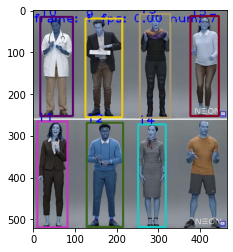

In [27]:
from matplotlib import pyplot as plt

plt.imshow(online_im)

In [8]:
a = np.random.randint(10,20,(12,20,5))
print(a.shape)
print(len(a))
for i, img_pred in enumerate(a):
    print("")

(12, 20, 5)
12












